# REQUIREMENTS

In [1]:
import wrds, datetime
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

conn = wrds.Connection()

/Users/armanozcan/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Loading library list...
Done


# DATA COLLECTION

In [2]:
query_start_date = '1990-01-01'

In [3]:
sp500_data = conn.raw_sql(f"""
SELECT
    caldt AS date,
    sprtrn AS daily_return -- Equal-Weighted Return (includes distributions) (ewretd)
FROM
    crspq.dsp500
WHERE
    caldt >= '{query_start_date}'
ORDER BY
    caldt;
""")
sp500_data['date'] = pd.to_datetime(sp500_data['date'])

sp500_data

,date,daily_return
0,1990-01-02,0.017799
1,1990-01-03,-0.002586
2,1990-01-04,-0.008613
3,1990-01-05,-0.009756
4,1990-01-08,0.004514
...,...,...
8748,2024-09-24,0.002511
8749,2024-09-25,-0.001861
8750,2024-09-26,0.004039
8751,2024-09-27,-0.001253


In [4]:
risk_free_data = conn.raw_sql(f'''
    SELECT
        date,
        rf AS daily_rf_rate -- One Month Treasury Bill Rate (daily)
    FROM
        ff.factors_daily
    WHERE
        date >= '{query_start_date}'
''')

risk_free_data['date'] = pd.to_datetime(risk_free_data['date'])

risk_free_data

,date,daily_rf_rate
0,1990-01-02,0.00026
1,1990-01-03,0.00026
2,1990-01-04,0.00026
3,1990-01-05,0.00026
4,1990-01-08,0.00026
...,...,...
8771,2024-10-25,0.00017
8772,2024-10-28,0.00017
8773,2024-10-29,0.00017
8774,2024-10-30,0.00017


In [5]:
last_trading_days = conn.raw_sql(f'''
SELECT DISTINCT
    MAX(date) AS last_trade_date
FROM crsp.dsf
WHERE date >= '{query_start_date}'
GROUP BY DATE_TRUNC('month', date)
ORDER BY last_trade_date
''')

last_trading_days['last_trade_date'] = pd.to_datetime(last_trading_days['last_trade_date'])
last_trading_days['month'] = last_trading_days['last_trade_date'].dt.month
last_trading_days['year'] = last_trading_days['last_trade_date'].dt.year
last_trading_day_mapping = last_trading_days.set_index(['year', 'month'])['last_trade_date'].to_dict()
last_trading_days

,last_trade_date,month,year
0,1990-01-31,1,1990
1,1990-02-28,2,1990
2,1990-03-30,3,1990
3,1990-04-30,4,1990
4,1990-05-31,5,1990
...,...,...,...
403,2023-08-31,8,2023
404,2023-09-29,9,2023
405,2023-10-31,10,2023
406,2023-11-30,11,2023


# Choosing Companies

In [6]:
# retrieves ID (permno) and earliest recorded name for each company in CRSP database
# 37,776 companies available

comps = conn.raw_sql( '''
SELECT permno, MIN(comnam) AS company_name
FROM crsp.stocknames
GROUP BY permno
''')
comps

,permno,company_name
0,83264,GREIF BROTHERS CORP
1,63618,HINDERLITER ENERGY EQUIP CORP
2,10896,CAMILLE ST MORITZ INC
3,69906,SEIBELS BRUCE GROUP INC
4,79030,GREAT CENTRAL MINES LTD
...,...,...
37771,14886,ARK E T F TRUST
37772,79163,A M F M INC
37773,86036,BRENTWOOD INSTRUMENTS INC
37774,92970,CHINA EDUCATION ALLIANCE INC


In [7]:
#TODO: choose a way to narrow the above list of permnos to <500. Will then use that list with the following functions to gather fin data
#this will go away when the above is completed.

company_search = 'AMAZON' # FIND A COMPANY HERE

comps[comps['company_name'].str.contains(f'{company_search}')]

,permno,company_name
9682,84788,AMAZON COM INC


# Helper functions

In [ ]:
# # HERE IS THE PROBLEM!!!
# bank_of_america_permno = '007647' 
# microsoft_permno = '012141'
# example = get_company_financials(bank_of_america_permno)
# example

NameError: name 'get_company_financials' is not defined

In [ ]:
def get_comp_data(permno, gvkey):

    company_fin_data = get_company_financials(gvkey)
    
    #forward fill (to make monthly)
    company_fin_data = company_fin_data.ffill().dropna()
    
    if company_fin_data.empty:
        return None
    
    #PiT
    company_fin_data = make_PiT(company_fin_data)
    
    company_stock_prcs = get_prices(permno)
    
    # Create new columns with just year and month
    company_fin_data['year_month'] = company_fin_data['date'].dt.strftime('%Y-%m')
    company_stock_prcs['year_month'] = company_stock_prcs['date'].dt.strftime('%Y-%m')
    
    company = pd.merge(company_fin_data, company_stock_prcs, on='year_month')

    company.drop(columns=['year_month', 'date_y'], axis=1, inplace=True)
    company.rename(columns={'date_x':'date'}, inplace=True)
    # company = pd.merge(company_fin_data, company_stock_prcs, on='date', how='inner')
    # company['date'] = company['reporting_date'] # backtest logic TODO
    return company

In [10]:
def get_company_financials(gvkey):
    company_fin_data = conn.raw_sql(f'''
    SELECT
        datadate AS date,
        gvkey AS gvkey,
        rdq AS reporting_date, -- Date of which information was reported
        atq AS total_assets,  -- Total Assets
        chq AS cash_holdings,  -- Cash and Short-Term Investments
        dlttq + dlcq AS total_debt,  -- Total Debt (long-term + short-term debt)
        ibq AS earnings,  -- Earnings before extraordinary items
        xrdq AS rd_expense,  -- R&D expense
        dvpq AS dividends_paid,  -- Dividends paid
        xintq AS interest_expense  -- Interest expense
    FROM
        comp.fundq
    WHERE
        gvkey = '{gvkey}'
        AND datadate >= '{query_start_date}'  -- Ensure data is after the link start date
    ''')
    
    company_fin_data['date'] = pd.to_datetime(company_fin_data['date'])
    company_fin_data['reporting_date'] = pd.to_datetime(company_fin_data['reporting_date'])
    
    start_date = company_fin_data['date'].min()
    end_date = company_fin_data['date'].max()
    all_months = pd.date_range(start=start_date, end=end_date, freq='ME')
    full_range_df = pd.DataFrame({'date': all_months})
    company_fin_data = pd.merge(full_range_df, company_fin_data, on='date', how='left')
    
    company_fin_data['month_start'] = company_fin_data['date'] - pd.offsets.MonthBegin()
    company_fin_data['month_end'] = company_fin_data['date']
    
    return company_fin_data

In [11]:
def make_PiT(company_fin_data):
    company_fin_data['reporting_date'] = pd.to_datetime(company_fin_data['reporting_date']) + pd.Timedelta(days=1)
    company_fin_data['month'] = company_fin_data['reporting_date'].dt.month
    company_fin_data['year'] = company_fin_data['reporting_date'].dt.year
    
    company_fin_data['EOM_trade_date'] = company_fin_data.apply(
        lambda row: last_trading_day_mapping.get((row['year'], row['month'])),
        axis=1
    )
    company_fin_data.drop(columns=['date','month','year','reporting_date'], axis=1, inplace=True)
    company_fin_data.rename(columns={'EOM_trade_date':'date'}, inplace=True)
    company_fin_data = company_fin_data[company_fin_data.columns[-1:].append(company_fin_data.columns[:-1])]
    company_fin_data['date'] = pd.to_datetime(company_fin_data['date'])
    return company_fin_data

In [12]:
def get_gvkey(permno):
    link = conn.raw_sql(f'''
    SELECT *
    FROM crsp.ccmxpf_linktable
    WHERE lpermno = {permno};
    ''')
    
    return link['gvkey'][0]

In [13]:
def get_prices(permno):
    company_stock_prcs = conn.raw_sql(f'''
    SELECT
        date,
        prc AS stock_price,
        ret AS stock_return,  -- Stock returns from CRSP
        prc * shrout AS market_cap  -- Market cap
    FROM
        crsp.msf
    WHERE
        permno = {permno}
    ''')
    
    company_stock_prcs['date'] = pd.to_datetime(company_stock_prcs['date'])
    
    return company_stock_prcs

In [14]:
#calculations for cash-hedging & returns
def calculate_returns(company, lower = 0.01, upper = 0.99):
    company['cash_share_weight'] = (company['cash_holdings'] / company['total_assets'])
    company['cash_holdings_t_minus_1'] = company['cash_holdings'].shift()
    
    calculate_b_it(company)
    calculate_e_it(company)
    company['cash_hedged_return'] = winsorize(company['cash_hedged_return'], lower, upper)

In [15]:
def calculate_b_it(company):
    data = company.copy()
    data['market_cap_t_minus_1'] = data['market_cap'].shift() # paper uses M_{t-1} for the denoms
    data['leverage'] = data['total_debt'] / (data['total_debt'] + data['market_cap'])
    
    # Y VALUES
    data['r_minus_R'] = data['stock_return'] - data['rf_rate']
    
    # REGRESSION VARIABLES
    data['gamma_1'] = (data['cash_holdings'].diff()) / data['market_cap_t_minus_1']
    data['gamma_2'] = (data['earnings'].diff()) / data['market_cap_t_minus_1']
    data['gamma_3'] = ((data['total_assets'] - data['cash_holdings']).diff()) / data['market_cap_t_minus_1']
    data['gamma_4'] = (data['rd_expense'].diff()) / data['market_cap_t_minus_1']
    data['gamma_5'] = (data['interest_expense'].diff()) / data['market_cap_t_minus_1']
    data['gamma_6'] = (data['dividends_paid'].diff()) / data['market_cap_t_minus_1']
    data['gamma_7']= data['cash_holdings_t_minus_1'] / data['market_cap_t_minus_1']
    data['gamma_8'] = data['leverage']
    data['gamma_9'] = (data['total_debt'].diff() + data['market_cap_t_minus_1'].diff()) / (data['total_debt'].shift() + data['market_cap_t_minus_1'].shift())
    data['gamma_10'] = (data['market_cap_t_minus_1'] * (data['cash_holdings'].diff())) / (data['market_cap'] ** 2)
    data['gamma_11'] = (data['leverage'] * (data['cash_holdings'].diff())) / data['market_cap']
    
    data = data.dropna()
    
    y = data['r_minus_R']
    X = data[['gamma_1', 'gamma_2', 'gamma_3', 'gamma_4', 'gamma_5', 'gamma_6', 'gamma_7', 'gamma_8', 'gamma_9', 'gamma_10', 'gamma_11']]
    
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    
    #print(model.summary())
    
    data['marginal_cash_value'] = (
        model.params.iloc[0] +
        (model.params.iloc[10] * (data['cash_holdings_t_minus_1'] / data['market_cap_t_minus_1'])) +
        (model.params.iloc[11] * data['leverage'])
    )
    
    data['average_cash_value'] = data['marginal_cash_value'] * data['cash_holdings']
    
    company['b_it'] = data['average_cash_value'].pct_change()  # monthly cash return

In [16]:
def calculate_e_it(company):
    company['cash_hedged_return'] = (1 / (1 - company['cash_share_weight'])) * (company['stock_return'] - (company['cash_share_weight']  * company['b_it']))

In [17]:
def winsorize(series, lower=0.01, upper=0.99):
    lower_threshold = series.quantile(lower)
    upper_threshold = series.quantile(upper)
    return series.clip(lower=lower_threshold, upper=upper_threshold)

In [18]:
window = 65 # months

def calculate_rolling_beta(stock_return, market_return, window = 65):
    rolling_cov = stock_return.rolling(window).cov(market_return)
    rolling_var = market_return.rolling(window).var()
    return rolling_cov / rolling_var

# Getting Aggregate & Cleaned Data

## Getting Companies Permno

In [19]:
query = '''
SELECT column_name, data_type, character_maximum_length
FROM information_schema.columns
WHERE table_name = 'msf' AND table_schema = 'crsp';
'''

table = conn.raw_sql(query)
print(table)

   column_name          data_type  character_maximum_length
0        cusip  character varying                       8.0
1       permno            integer                       NaN
2       permco            integer                       NaN
3       issuno            integer                       NaN
4        hexcd           smallint                       NaN
5       hsiccd            integer                       NaN
6         date               date                       NaN
7        bidlo            numeric                       NaN
8        askhi            numeric                       NaN
9          prc            numeric                       NaN
10         vol            numeric                       NaN
11         ret            numeric                       NaN
12         bid            numeric                       NaN
13         ask            numeric                       NaN
14      shrout   double precision                       NaN
15      cfacpr   double precision       

In [ ]:
# query = '''
# SELECT DISTINCT ON (a.permno) 
#     a.permno, 
#     a.cusip,
#     a.ret AS returns,
#     a.date
# FROM crsp.msf a
# WHERE a.date > '2000-01-01'
# GROUP BY a.permno, a.date, a.ret, a.cusip
# HAVING COUNT(*) = COUNT(a.ret) -- Ensure all rows have non-NULL returns
#    AND MIN(a.prc) >= 1; -- Ensure share price has never been below 1 dollar
# '''

# table = conn.raw_sql(query)
# print(table)


       permno     cusip   returns        date
0       10001  36720410  0.011044  2015-04-30
1       10002  05978R10  0.028931  2000-03-31
2       10009  46334710  0.001894  2000-10-31
3       10012  23326910 -0.255556  2000-10-31
4       10016  81002230 -0.016234  2000-08-31
...       ...       ...       ...         ...
22335   93432  47737R10  0.082192  2011-04-29
22336   93433  92870X30 -0.019868  2014-10-31
22337   93434  78513510 -0.079710  2022-05-31
22338   93435  82936G20 -0.001718  2010-09-30
22339   93436  88160R10  0.555160  2020-01-31

[22340 rows x 4 columns]


In [ ]:
# query = """
# SELECT DISTINCT ON (a.permno) 
#     a.permno, 
#     a.permco, 
#     a.cusip,
#     a.hsiccd, 
#     (a.prc * ABS(a.shrout)) AS market_cap, -- Market Cap
#     a.ret AS returns, -- Returns
#     a.date
# FROM crsp.msf a
# WHERE a.prc IS NOT NULL AND a.shrout IS NOT NULL and a.date >= '2000-01-01' -- Exclude rows where market cap cannot be calculated
# ORDER BY a.permno, a.date DESC;
# """

# table = conn.raw_sql(query)
# permnos = table['permno'].to_list()
# print(table)


       permno  permco     cusip  hsiccd    market_cap   returns        date
0       10001    7953  36720410  4925.0  1.362340e+05  0.001934  2017-07-31
1       10002    7954  05978R10  6020.0  5.174208e+04  0.035971  2013-01-31
2       10009    7965  46334710  6030.0  7.627519e+04  0.001894  2000-10-31
3       10012    7969  23326910  3674.0  4.036650e+03 -0.190476  2005-07-29
4       10016    1728  81002230  3812.0  3.986540e+05  0.062147  2001-04-30
...       ...     ...       ...     ...           ...       ...         ...
22488   93432   53450  47737R10  7389.0  4.217136e+04 -0.350211  2011-05-31
22489   93433   53451  92870X30  9999.0  2.473625e+04  0.279070  2016-11-30
22490   93434   53427  78513510  9999.0  3.012730e+04  0.065449  2023-12-29
22491   93435   53452  82936G20  6163.0  4.200064e+04 -0.345725  2012-04-30
22492   93436   53453  88160R10  9999.0  7.898983e+08  0.034988  2023-12-29

[22493 rows x 7 columns]


In [28]:
query = """
SELECT *
FROM (
    SELECT DISTINCT ON (a.permno) 
        a.permno, 
        a.permco, 
        a.cusip, 
        a.comnam, 
        a.end_date, 
        a.st_date,
        a.siccd
    FROM crsp.stocknames a
    WHERE a.hexcd IN (3) and a.end_date = '2023-12-29' and a.st_date <= '2000-01-01' and (a.siccd < 6000 or a.siccd > 6799)
    ORDER BY a.permno, a.end_date DESC
) subquery
ORDER BY end_date DESC;

"""

table = conn.raw_sql(query)
permnos = table['permno'].to_list()
print(table)


     permno  permco     cusip                            comnam    end_date  \
0     10026    7976  46603210            J & J SNACK FOODS CORP  2023-12-29   
1     10032    7980  72913210                       PLEXUS CORP  2023-12-29   
2     10044    7992  77467X10  ROCKY MOUNTAIN CHOCOLATE FAC INC  2023-12-29   
3     10066    6331  35518410                  ABM COMPUTER SYS  2023-12-29   
4     10107    8048  59491810                    MICROSOFT CORP  2023-12-29   
..      ...     ...       ...                               ...         ...   
609   88779    7343  44934S20                        HOWTEK INC  2023-12-29   
610   89456    7459  50216C10            L S I LIGHTING SYS INC  2023-12-29   
611   89858   34920  72650310     PLAINS ALL AMERN PIPELINE L P  2023-12-29   
612   89915    7301  58058910                  MCGRATH RENTCORP  2023-12-29   
613   91556    7684  77829610                   ROSS STORES INC  2023-12-29   

        st_date  siccd  
0    1986-02-04   2050  
1

In [ ]:
#permnos = [10107, 86580, 84788]
# BELOW IS THE LIST OF PERMNOs FOR TEN COMPANIES

# query = """
# select distinct on (a.permno) a.permno, a.permco, a.cusip, a.comnam 
# from crsp.stocknames a
# where a.comnam ilike '%%alphabet%%' and a.cusip like '02079K30'
#     or a.comnam ilike '%%amazon%%'
#     or a.comnam ilike 'apple inc%%'
#     or a.comnam ilike '%%meta platforms%%'
#     or a.comnam ilike '%%microsoft%%'
#     or a.comnam ilike '%%nvidia%%'
#     or a.comnam ilike '%%tesla inc%%'
#     or a.comnam ilike '%%netflix%%'
#     or a.comnam ilike '%%walmart%%'
#     or a.comnam ilike '%%pfizer%%'
#     or a.comnam ilike '%%bank of america%%'
# ;
# """

# table = conn.raw_sql(query)
# permnos = table['permno'].to_list()
# print(table)

# or a.comnam ilike '%%home depot%%'    
# or a.comnam ilike '%%verizon%%'
# or a.comnam ilike '%%disney%%'
# or a.comnam ilike '%%mcdonald%%'
# or a.comnam ilike '%%starbucks%%'
# or a.comnam ilike '%%at&t%%'
# or a.comnam ilike '%%mastercard%%'

# or a.comnam ilike '%%johnson & johnson%%'
# or a.comnam ilike '%%jpmorgan chase%%'
# or a.comnam ilike '%%visa inc%%'
# or a.comnam ilike '%%exxon mobil%%'

# or a.comnam ilike '%%coca-cola%%'
# or a.comnam ilike '%%pepsico%%'


    permno  permco     cusip                comnam
0    10107    8048  59491810        MICROSOFT CORP
1    13407   54084  30303M10    META PLATFORMS INC
2    14593       7  03783310             APPLE INC
3    21936   21394  71708110            PFIZER INC
4    55976   21880  93114210           WALMART INC
5    59408    3151  06050510  BANK OF AMERICA CORP
6    84788   15473  02313510        AMAZON COM INC
7    86580   16382  67066G10           NVIDIA CORP
8    89393   43145  64110L10           NETFLIX INC
9    90319   45483  02079K30          ALPHABET INC
10   93436   53453  88160R10             TESLA INC


In [30]:
gvkeys = [get_gvkey(permno) for permno in permnos]
print(len(gvkeys))
assert(len(gvkeys) == len(permnos))
print(gvkeys)
print(f'There are {len(permnos)} companies in the list.')

614
['012825', '012945', '011976', '001008', '012141', '001300', '012181', '012304', '012381', '001979', '012252', '012568', '012262', '012266', '012392', '012926', '012377', '012379', '012482', '012458', '012597', '012598', '012575', '012840', '012915', '004001', '012947', '013733', '013176', '013200', '013602', '013239', '013235', '001210', '013381', '013794', '013421', '001050', '013582', '001234', '013700', '014225', '013786', '013765', '012972', '013906', '001266', '014113', '014309', '003138', '014983', '015087', '014891', '014603', '001562', '008479', '001602', '001686', '001690', '001704', '016668', '001783', '001823', '001820', '010499', '005234', '002001', '002080', '002124', '002237', '002390', '011264', '003708', '002573', '064275', '002615', '001045', '002807', '008539', '003062', '007977', '006338', '001440', '003275', '003278', '003358', '012717', '003570', '007138', '001919', '011636', '003761', '003807', '003691', '003158', '004124', '004186', '004225', '004275', '0043

## Populating Company Data

In [ ]:
agg_fin_data = pd.DataFrame(columns=['date', 'gvkey', 'reporting_date', 'total_assets', 'cash_holdings',
       'total_debt', 'earnings', 'rd_expense', 'dividends_paid',
       'interest_expense', 'stock_price', 'stock_return', 'market_cap',
       'snp_return', 'rf_rate', 'cash_share_weight', 'cash_holdings_t_minus_1',
       'b_it', 'cash_hedged_return', 'company_beta', 'cash_hedged_beta', 'comnam'])

# Create a mapping from permno to comnam
comnam_mapping = table.set_index('permno')['comnam'].to_dict()


for i in range(len(permnos)):
    print(f'Trying to get the data of the {i}th company out of {len(permnos)} companies.')
    try:
        # Try to get the company data
        company = get_comp_data(permnos[i], gvkeys[i])
        
        # If the company table is empty, skip it
        if company.empty:
            print(f'The {i}th company with permno {permnos[i]} has no data. Skipping...')
            continue
        
        # Add the company name (comnam) to the company DataFrame
        company['comnam'] = comnam_mapping.get(permnos[i], 'Unknown')
        
        # print(company)
        
        def aggregate_monthly(start_date, end_date, daily_data, column, agg_func):
            mask = (daily_data['date'] >= start_date) & (daily_data['date'] <= end_date)
            return agg_func(daily_data.loc[mask, column])
        
        company['snp_return'] = company.apply(
            lambda row: aggregate_monthly(row['month_start'], row['month_end'], sp500_data, 'daily_return', 
                                          lambda x: np.prod(1 + x) - 1), axis=1
        )
        
        company['rf_rate'] = company.apply(
            lambda row: aggregate_monthly(row['month_start'], row['month_end'], risk_free_data, 'daily_rf_rate', 
                                          lambda x: np.prod(1 + x) - 1), axis=1
        )
        
        company.drop(columns=['month_start', 'month_end'], axis=1, inplace=True)
        
        calculate_returns(company)
        
        company['company_beta'] = calculate_rolling_beta(company['stock_return'], company['snp_return'], window)
        company['cash_hedged_beta'] = calculate_rolling_beta(company['cash_hedged_return'], company['snp_return'], window)
        
        if not agg_fin_data.empty:
            agg_fin_data = pd.concat([agg_fin_data, company], ignore_index=True)
        else:
            agg_fin_data = company
    
    except Exception as e:
        # Catch any errors, log the permno and the error, then skip
        print(f"Error with permno {permnos[i]}: {e}. Skipping...")
        continue

agg_fin_data = agg_fin_data.sort_values(by='date').reset_index(drop=True)

agg_fin_data

          date   gvkey  total_assets  cash_holdings  total_debt  earnings  \
0   2007-01-31  012825       338.086         22.042       0.000     3.805   
1   2007-01-31  012825       338.086         22.042       0.000     3.805   
2   2007-01-31  012825       338.086         22.042       0.000     3.805   
3   2007-04-30  012825       348.967         23.414       0.000     5.333   
4   2007-04-30  012825       348.967         23.414       0.000     5.333   
..         ...     ...           ...            ...         ...       ...   
199 2023-08-31  012825      1304.097         65.643     171.874    34.981   
200 2023-08-31  012825      1304.097         65.643     171.874    34.981   
201 2023-11-30  012825      1277.236         49.581     121.910    30.421   
202 2023-11-30  012825      1277.236         49.581     121.910    30.421   
203 2023-11-30  012825      1277.236         49.581     121.910    30.421   

     rd_expense  dividends_paid  interest_expense month_start  month_end  \

/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


          date   gvkey  total_assets  cash_holdings  total_debt  earnings  \
0   2009-09-30  014603        26.213         12.778       4.565    -2.428   
1   2009-09-30  014603        26.213         12.778       4.565    -2.428   
2   2009-09-30  014603        26.213         12.778       4.565    -2.428   
3   2009-12-31  014603        27.529         13.599       4.003    -2.787   
4   2009-12-31  014603        27.529         13.599       4.003    -2.787   
..         ...     ...           ...            ...         ...       ...   
169 2023-09-29  014603       443.006         24.898     189.483    -2.122   
170 2023-09-29  014603       443.006         24.898     189.483    -2.122   
171 2023-12-29  014603       455.485         31.424     196.696    -9.521   
172 2023-12-29  014603       455.485         31.424     196.696    -9.521   
173 2023-12-29  014603       455.485         31.424     196.696    -9.521   

     rd_expense  dividends_paid  interest_expense month_start  month_end  \

/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


          date   gvkey  total_assets  cash_holdings  total_debt  earnings  \
0   2007-04-30  024197       646.494         53.937      82.175    21.027   
1   2007-04-30  024197       646.494         53.937      82.175    21.027   
2   2007-04-30  024197       646.494         53.937      82.175    21.027   
3   2007-07-31  024197       646.169         49.588      90.539    21.664   
4   2007-07-31  024197       646.169         49.588      90.539    21.664   
..         ...     ...           ...            ...         ...       ...   
196 2023-08-31  024197      2870.806        132.838    1152.865   224.236   
197 2023-08-31  024197      2870.806        132.838    1152.865   224.236   
198 2023-11-30  024197      3086.404        331.696    1140.165   212.231   
199 2023-11-30  024197      3086.404        331.696    1140.165   212.231   
200 2023-11-30  024197      3086.404        331.696    1140.165   212.231   

     rd_expense  dividends_paid  interest_expense month_start  month_end  \

/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


          date   gvkey  total_assets  cash_holdings  total_debt  earnings  \
0   2007-05-31  010991      1805.658         33.231     924.070    24.759   
1   2007-05-31  010991      1805.658         33.231     924.070    24.759   
2   2007-05-31  010991      1805.658         33.231     924.070    24.759   
3   2007-08-31  010991      1982.974         27.811    1033.272    27.107   
4   2007-08-31  010991      1982.974         27.811    1033.272    27.107   
..         ...     ...           ...            ...         ...       ...   
196 2023-08-31  010991      5962.000        909.000    3935.000    -1.000   
197 2023-08-31  010991      5962.000        909.000    3935.000    -1.000   
198 2023-11-30  010991      5887.000        891.000    3924.000    75.000   
199 2023-11-30  010991      5887.000        891.000    3924.000    75.000   
200 2023-11-30  010991      5887.000        891.000    3924.000    75.000   

     rd_expense  dividends_paid  interest_expense month_start  month_end  \

/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Company with permno 81184 has no data. Skipping...
Company with permno 81208 has no data. Skipping...
          date   gvkey  total_assets  cash_holdings  total_debt  earnings  \
0   2009-05-29  031453      1468.988         67.193     308.904    -6.797   
1   2009-05-29  031453      1468.988         67.193     308.904    -6.797   
2   2009-05-29  031453      1468.988         67.193     308.904    -6.797   
3   2009-08-31  031453      1543.995        119.820     308.904    12.893   
4   2009-08-31  031453      1543.995        119.820     308.904    12.893   
..         ...     ...           ...            ...         ...       ...   
172 2023-08-31  031453      5542.331        195.954    1018.161    80.482   
173 2023-08-31  031453      5542.331        195.954    1018.161    80.482   
174 2023-11-30  031453      5078.216        244.324     942.182    60.247   
175 2023-11-30  031453      5078.216        244.324     942.182    60.247   
176 2023-11-30  031453      5078.216        244.324

,date,gvkey,total_assets,cash_holdings,total_debt,earnings,rd_expense,dividends_paid,interest_expense,stock_price,...,market_cap,comnam,snp_return,rf_rate,cash_share_weight,cash_holdings_t_minus_1,b_it,cash_hedged_return,company_beta,cash_hedged_beta
0,1997-02-28,001234,63.251,0.144,7.016,0.105,1.003,0.0,0.056,16.000,...,51440.00,ALABAMA TENNESSEE NATURAL GAS CO,0.061317,0.004409,0.002277,0.144,NaN,NaN,NaN,NaN
1,1997-02-28,001234,63.251,0.144,7.016,0.105,1.003,0.0,0.056,16.000,...,51440.00,ALABAMA TENNESSEE NATURAL GAS CO,0.005929,0.003807,0.002277,0.144,NaN,NaN,NaN,NaN
2,1997-02-28,001234,63.251,0.144,7.016,0.105,1.003,0.0,0.056,16.000,...,51440.00,ALABAMA TENNESSEE NATURAL GAS CO,-0.021507,0.004630,0.002277,NaN,NaN,NaN,NaN,NaN
3,1997-05-30,001234,58.269,0.174,8.019,0.241,0.191,0.0,0.056,13.875,...,47452.50,ALABAMA TENNESSEE NATURAL GAS CO,-0.042614,0.004208,0.002986,0.144,0.497081,0.171946,NaN,NaN
4,1997-05-30,001234,58.269,0.174,8.019,0.241,0.191,0.0,0.056,13.875,...,47452.50,ALABAMA TENNESSEE NATURAL GAS CO,0.058576,0.004841,0.002986,0.174,0.000000,0.173435,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85689,2023-12-29,004900,74.729,8.708,6.895,0.797,0.841,0.0,0.029,10.950,...,103094.25,FREQUENCY ELECTRONICS INC,0.089178,0.004419,0.116528,8.708,0.000196,0.123829,0.516023,0.272012
85690,2023-12-29,004900,74.729,8.708,6.895,0.797,0.841,0.0,0.029,10.950,...,103094.25,FREQUENCY ELECTRONICS INC,-0.021980,0.004630,0.116528,9.061,-0.425044,0.179917,0.499915,0.237833
85691,2023-12-29,007921,5251.770,115.679,1862.909,127.778,71.400,0.0,26.973,264.160,...,15058969.12,NORDSON CORP,0.044230,0.004208,0.022027,115.679,0.000000,0.128174,0.405572,0.319035
85692,2023-12-29,008864,137.021,13.133,22.204,-12.015,2.597,0.0,0.185,4.200,...,59602.20,QUARTZ ENGINEERING & MATLS INC,0.089178,0.004419,0.095847,13.133,0.000000,-0.505848,-0.099156,-0.018745


In [38]:
# look at the number of unique permnos in agg_fin_data
print(f"Number of companies initially was {len(permnos)} but we could only get the data of {len(agg_fin_data['gvkey'].unique())} companies.")


Number of companies initially was 614 but we could only get the data of 444 companies.


In [ ]:
# Simplify agg_fin_data by keeping only the required columns
data = agg_fin_data[['date', 'gvkey', 'comnam', 'stock_return', 'market_cap', 'cash_hedged_return', 'b_it']]
data[:50]

,date,gvkey,comnam,stock_return,market_cap,cash_hedged_return,b_it
0,2007-01-31,001690,APPLE INC,0.010490,7.388854e+07,NaN,NaN
1,2007-01-31,001690,APPLE INC,0.010490,7.388854e+07,NaN,NaN
2,2007-01-31,001690,APPLE INC,0.010490,7.388854e+07,NaN,NaN
3,2007-04-30,160329,ALPHABET INC,0.028855,1.091113e+08,NaN,NaN
4,2007-04-30,160329,ALPHABET INC,0.028855,1.091113e+08,NaN,NaN
5,2007-04-30,147579,NETFLIX INC,-0.043985,1.513324e+06,NaN,NaN
6,2007-04-30,147579,NETFLIX INC,-0.043985,1.513324e+06,NaN,NaN
7,2007-04-30,147579,NETFLIX INC,-0.043985,1.513324e+06,NaN,NaN
8,2007-04-30,008530,PFIZER INC,0.047506,1.872528e+08,NaN,NaN
9,2007-04-30,008530,PFIZER INC,0.047506,1.872528e+08,NaN,NaN


In [ ]:
# Group the data by 'gvkey' and store each group's DataFrame in a dictionary
company_tables = {gvkey: group for gvkey, group in data.groupby('gvkey')}

# Example: Access the DataFrame for a specific gvkey
example_gvkey = list(company_tables.keys())[0]  # Get the first gvkey
example_table = company_tables[example_gvkey]

# Print the first few rows of the table for the example gvkey
print(f"Subtable for gvkey {example_gvkey}:\n", example_table.head(50))


Subtable for gvkey 001690:
           date   gvkey     comnam  stock_return    market_cap  \
0   2007-01-31  001690  APPLE INC      0.010490  7.388854e+07   
1   2007-01-31  001690  APPLE INC      0.010490  7.388854e+07   
2   2007-01-31  001690  APPLE INC      0.010490  7.388854e+07   
11  2007-04-30  001690  APPLE INC      0.074158  8.632181e+07   
14  2007-04-30  001690  APPLE INC      0.074158  8.632181e+07   
15  2007-04-30  001690  APPLE INC      0.074158  8.632181e+07   
25  2007-07-31  001690  APPLE INC      0.079646  1.145839e+08   
31  2007-07-31  001690  APPLE INC      0.079646  1.145839e+08   
34  2007-07-31  001690  APPLE INC      0.079646  1.145839e+08   
45  2007-10-31  001690  APPLE INC      0.237701  1.651883e+08   
46  2007-10-31  001690  APPLE INC      0.237701  1.651883e+08   
51  2007-10-31  001690  APPLE INC      0.237701  1.651883e+08   
69  2008-01-31  001690  APPLE INC     -0.316640  1.189647e+08   
70  2008-01-31  001690  APPLE INC     -0.316640  1.189647e+08 

## Regular Return Portfolio

In [ ]:
import pandas as pd

# Assuming `data` contains the necessary data
# Ensure 'date' column is datetime type
data['date'] = pd.to_datetime(data['date'])

# Filter data for the required period (January 2010 to December 2020)
start_date = '2010-01-01'
end_date = '2020-12-31'
filtered_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

# Add a 'month' and 'year' column for monthly grouping
filtered_data['year'] = filtered_data['date'].dt.year
filtered_data['month'] = filtered_data['date'].dt.month

# Dictionary to store portfolio returns
portfolio_returns = []

# Group data by year and month
grouped = filtered_data.groupby(['year', 'month'])

# Iterate through each month
for (year, month), group in grouped:
    # Sort by market cap in descending order and select the top 5 companies
    top_5 = group.sort_values(by='market_cap', ascending=True).head(5)
    
    # Assign equal weights (20%) to the selected companies
    top_5['weight'] = 0.2
    
    # Calculate the portfolio return for the month
    portfolio_return = (top_5['weight'] * top_5['stock_return']).sum()
    
    # Store the result
    portfolio_returns.append({
        'year': year,
        'month': month,
        'portfolio_return': portfolio_return
    })

# Convert portfolio returns to a DataFrame
portfolio_returns_df = pd.DataFrame(portfolio_returns)

# Sort by year and month
portfolio_returns_df = portfolio_returns_df.sort_values(by=['year', 'month']).reset_index(drop=True)

# Display portfolio returns
print(portfolio_returns_df.head(50))

# Optionally, save to CSV
# portfolio_returns_df.to_csv("monthly_portfolio_returns_2010_2020.csv", index=False)


    year  month  portfolio_return
0   2010      1          0.050893
1   2010      2          0.011644
2   2010      4          0.208638
3   2010      5         -0.129494
4   2010      6          0.000000
5   2010      7         -0.002092
6   2010      8         -0.007965
7   2010     10          0.063025
8   2010     11          0.423464
9   2011      1          0.108042
10  2011      2         -0.026299
11  2011      4          0.021925
12  2011      5          0.056017
13  2011      7          0.042806
14  2011      8         -0.088096
15  2011     10         -0.170248
16  2011     11          0.091278
17  2012      1          0.400100
18  2012      2          0.099868
19  2012      4         -0.123972
20  2012      5         -0.083279
21  2012      7         -0.142166
22  2012      8          0.022379
23  2012     10          0.263165
24  2012     11          0.123667
25  2013      1          0.536320
26  2013      2         -0.027371
27  2013      4          0.065889
28  2013      

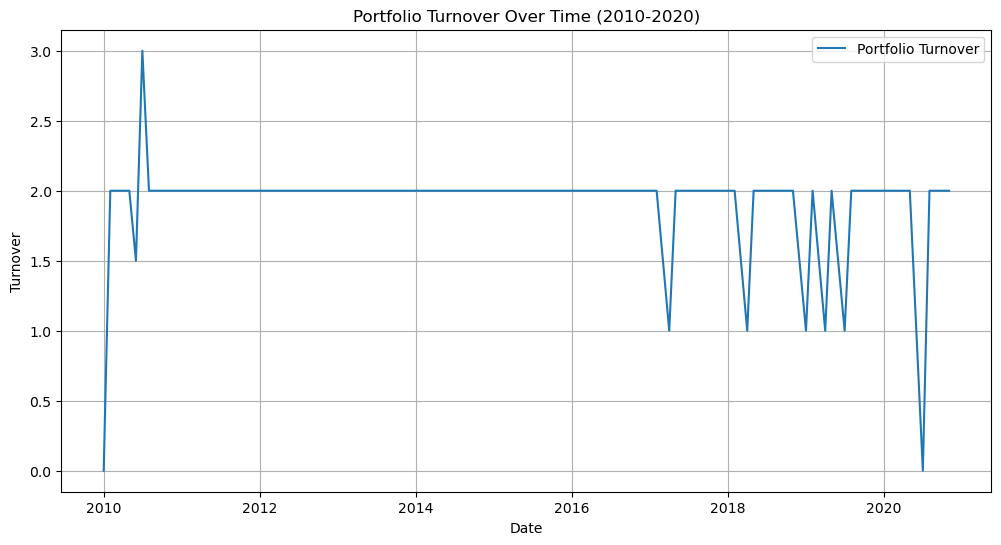

In [ ]:
import matplotlib.pyplot as plt

# Initialize variables for turnover calculation
prev_top_5 = set()
turnover_data = []

# Calculate turnover
for (year, month), group in grouped:
    # Sort by market cap in descending order and select the top 5 companies
    top_5 = group.sort_values(by='market_cap', ascending=False).head(5)
    current_top_5 = set(top_5['gvkey'])
    
    # Calculate turnover: fraction of companies that are replaced
    if prev_top_5:
        turnover = len(current_top_5.symmetric_difference(prev_top_5)) / len(prev_top_5)
    else:
        turnover = 0  # No turnover for the first month
    
    turnover_data.append({'year': year, 'month': month, 'turnover': turnover})
    prev_top_5 = current_top_5

# Convert turnover data to a DataFrame
turnover_df = pd.DataFrame(turnover_data)

# Sort by year and month
turnover_df = turnover_df.sort_values(by=['year', 'month']).reset_index(drop=True)

# Create a date column for plotting
turnover_df['date'] = pd.to_datetime(turnover_df[['year', 'month']].assign(day=1))

# Plot turnover over time
plt.figure(figsize=(12, 6))
plt.plot(turnover_df['date'], turnover_df['turnover'], label='Portfolio Turnover')
plt.title('Portfolio Turnover Over Time (2010-2020)')
plt.xlabel('Date')
plt.ylabel('Turnover')
plt.legend()
plt.grid(True)
plt.show()


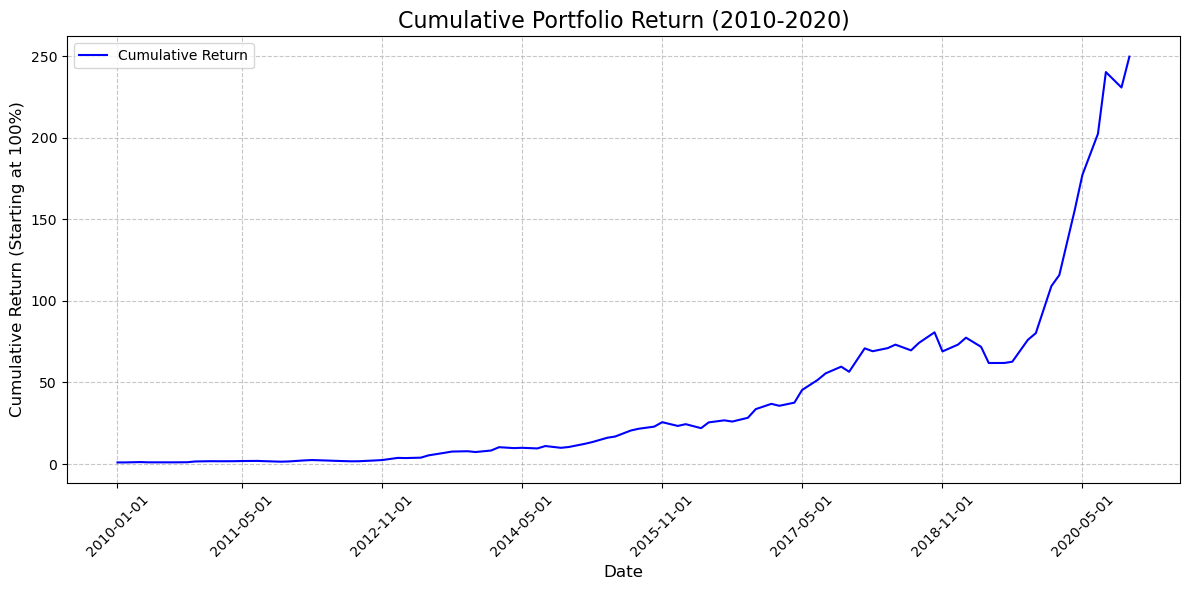

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Exclude the first month (January 2010) from cumulative return calculations
portfolio_returns_df.loc[portfolio_returns_df.index[0], 'portfolio_return'] = 0  # No return in January

# Start cumulative returns with 1.0 (100%) at the beginning
portfolio_returns_df['cumulative_return'] = (1 + portfolio_returns_df['portfolio_return']).cumprod()

# Create a proper date column for x-axis
portfolio_returns_df['date'] = pd.to_datetime(portfolio_returns_df['year'].astype(str) + '-' + portfolio_returns_df['month'].astype(str) + '-01')

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(portfolio_returns_df['date'], portfolio_returns_df['cumulative_return'], label='Cumulative Return', color='blue')

# Fix title and labels
plt.title('Cumulative Portfolio Return (2010-2020)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return (Starting at 100%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Format x-axis ticks for better readability
plt.xticks(portfolio_returns_df['date'][::12], rotation=45)  # Show one tick per year

# Add y-axis ticks at every integer value
y_min = int(portfolio_returns_df['cumulative_return'].min())
y_max = int(portfolio_returns_df['cumulative_return'].max()) + 1

#plt.yticks(np.arange(y_min, y_max, step=1))

# Show the plot
plt.tight_layout()
plt.show()


## Cash Hedged Portfolio

In [ ]:
import pandas as pd

# Assuming `data` contains the necessary data
# Ensure 'date' column is datetime type
data['date'] = pd.to_datetime(data['date'])

# Filter data for the required period (January 2010 to December 2020)
start_date = '2010-01-01'
end_date = '2020-12-31'
filtered_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

# Add a 'month' and 'year' column for monthly grouping
filtered_data['year'] = filtered_data['date'].dt.year
filtered_data['month'] = filtered_data['date'].dt.month

# Dictionary to store portfolio returns
portfolio_returns = []

# Group data by year and month
grouped = filtered_data.groupby(['year', 'month'])

# Iterate through each month
for (year, month), group in grouped:
    # Sort by market cap in descending order and select the top 5 companies
    top_5 = group.sort_values(by='market_cap', ascending=True).head(5)
    
    # Assign equal weights (20%) to the selected companies
    top_5['weight'] = 0.2
    
    # Calculate the portfolio return for the month
    portfolio_return = (top_5['weight'] * top_5['cash_hedged_return']).sum()
    
    # Store the result
    portfolio_returns.append({
        'year': year,
        'month': month,
        'portfolio_return': portfolio_return
    })

# Convert portfolio returns to a DataFrame
portfolio_returns_df = pd.DataFrame(portfolio_returns)

# Sort by year and month
portfolio_returns_df = portfolio_returns_df.sort_values(by=['year', 'month']).reset_index(drop=True)

# Display portfolio returns
print(portfolio_returns_df.head(50))

# Optionally, save to CSV
# portfolio_returns_df.to_csv("monthly_portfolio_returns_2010_2020.csv", index=False)


    year  month  portfolio_return
0   2010      1         -0.131727
1   2010      2          0.029397
2   2010      4          0.273827
3   2010      5         -0.148425
4   2010      6          0.000000
5   2010      7         -0.014818
6   2010      8         -0.011102
7   2010     10          0.093787
8   2010     11          0.536710
9   2011      1          0.116200
10  2011      2         -0.093288
11  2011      4          0.035375
12  2011      5          0.060754
13  2011      7          0.056145
14  2011      8         -0.498773
15  2011     10         -0.235077
16  2011     11          0.140657
17  2012      1          0.369189
18  2012      2          0.097420
19  2012      4         -0.125151
20  2012      5         -0.127157
21  2012      7         -0.207815
22  2012      8          0.020900
23  2012     10          0.298062
24  2012     11          0.149965
25  2013      1          0.592559
26  2013      2         -0.089620
27  2013      4          0.085006
28  2013      

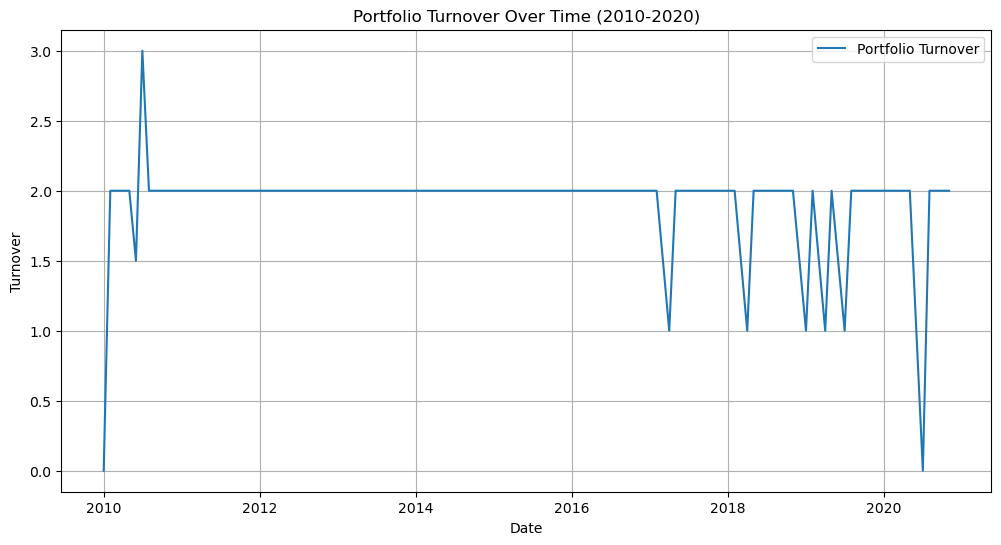

In [ ]:
import matplotlib.pyplot as plt

# Initialize variables for turnover calculation
prev_top_5 = set()
turnover_data = []

# Calculate turnover
for (year, month), group in grouped:
    # Sort by market cap in descending order and select the top 5 companies
    top_5 = group.sort_values(by='market_cap', ascending=False).head(5)
    current_top_5 = set(top_5['gvkey'])
    
    # Calculate turnover: fraction of companies that are replaced
    if prev_top_5:
        turnover = len(current_top_5.symmetric_difference(prev_top_5)) / len(prev_top_5)
    else:
        turnover = 0  # No turnover for the first month
    
    turnover_data.append({'year': year, 'month': month, 'turnover': turnover})
    prev_top_5 = current_top_5

# Convert turnover data to a DataFrame
turnover_df = pd.DataFrame(turnover_data)

# Sort by year and month
turnover_df = turnover_df.sort_values(by=['year', 'month']).reset_index(drop=True)

# Create a date column for plotting
turnover_df['date'] = pd.to_datetime(turnover_df[['year', 'month']].assign(day=1))

# Plot turnover over time
plt.figure(figsize=(12, 6))
plt.plot(turnover_df['date'], turnover_df['turnover'], label='Portfolio Turnover')
plt.title('Portfolio Turnover Over Time (2010-2020)')
plt.xlabel('Date')
plt.ylabel('Turnover')
plt.legend()
plt.grid(True)
plt.show()


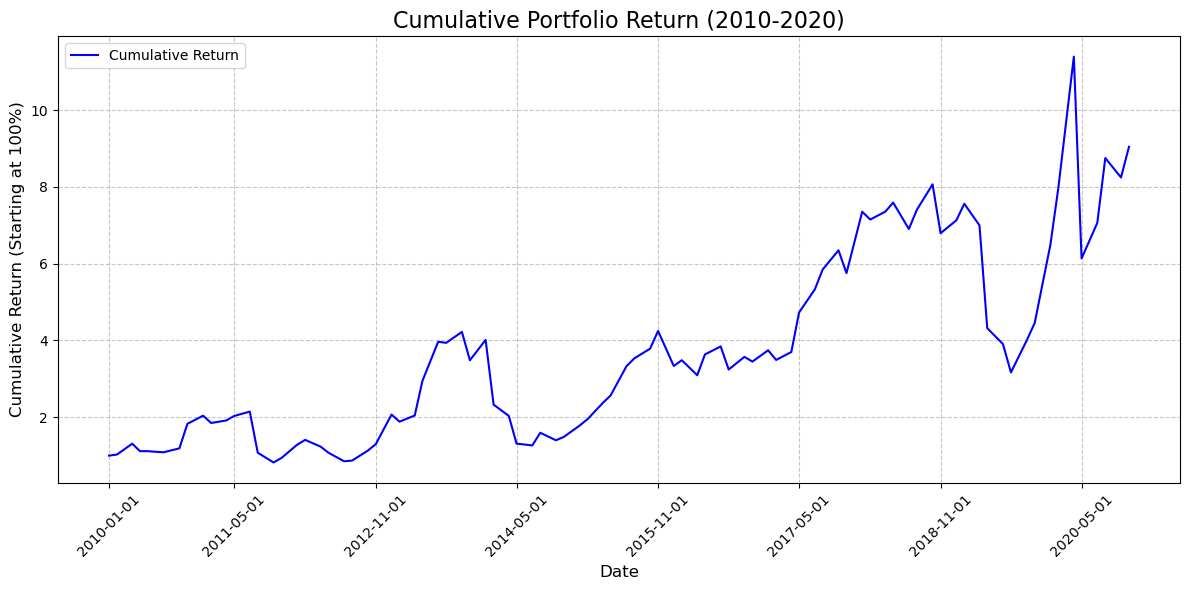

In [ ]:
import matplotlib.pyplot as plt

# Exclude the first month (January 2010) from cumulative return calculations
portfolio_returns_df.loc[portfolio_returns_df.index[0], 'portfolio_return'] = 0  # No return in January

# Start cumulative returns with 1.0 (100%) at the beginning
portfolio_returns_df['cumulative_return'] = (1 + portfolio_returns_df['portfolio_return']).cumprod()

# Create a proper date column for x-axis
portfolio_returns_df['date'] = pd.to_datetime(portfolio_returns_df['year'].astype(str) + '-' + portfolio_returns_df['month'].astype(str) + '-01')

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(portfolio_returns_df['date'], portfolio_returns_df['cumulative_return'], label='Cumulative Return', color='blue')

# Fix title and labels
plt.title('Cumulative Portfolio Return (2010-2020)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return (Starting at 100%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Format x-axis ticks for better readability
plt.xticks(portfolio_returns_df['date'][::12], rotation=45)  # Show one tick per year

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
print(portfolio_returns_df.head(10))


   year  month  portfolio_return  cumulative_return       date
0  2010      1          0.000000           1.000000 2010-01-01
1  2010      2          0.029397           1.029397 2010-02-01
2  2010      4          0.273827           1.311273 2010-04-01
3  2010      5         -0.148425           1.116647 2010-05-01
4  2010      6          0.000000           1.116647 2010-06-01
5  2010      7         -0.014818           1.100100 2010-07-01
6  2010      8         -0.011102           1.087887 2010-08-01
7  2010     10          0.093787           1.189916 2010-10-01
8  2010     11          0.536710           1.828555 2010-11-01
9  2011      1          0.116200           2.041034 2011-01-01


# Correlations

In [88]:
input_table = agg_fin_data[['date', 'gvkey',  'stock_return', 'b_it', 'cash_hedged_return']]
input_table = input_table.sort_values(by=['date'])
# remove any date where b_it or cash_hedged_return is NaN
input_table = input_table.dropna(subset=['b_it', 'cash_hedged_return', 'stock_return'])
# only keep one row per combination of date and gvkey
input_table = input_table.drop_duplicates(subset=['date', 'gvkey'], keep='first')
len(input_table)
input_table[:5]

,date,gvkey,stock_return,b_it,cash_hedged_return
3,1997-05-30,001234,0.172917,0.497081,0.171946
6,1997-08-29,001234,-0.096296,0.000000,-0.096545
11,1997-10-31,001234,0.072727,-0.000001,0.072918
12,1998-02-27,001234,-0.122642,0.000000,-0.259786
15,1998-05-29,001234,-0.069767,0.000624,-0.148391


In [111]:
import pandas as pd
import numpy as np
import random

def compute_random_correlations(data, compute_on='stock_return', num_iterations=1000):
    """
    Compute pairwise correlations between two randomly chosen companies over time, 
    based on stock returns or cash returns, a specified number of times.

    Parameters:
    - data (pd.DataFrame): A DataFrame with columns ['date', 'cash_return', 'stock_return', 'gvkey'].
    - compute_on (str): Column to compute correlations on ('stock_return', 'cash_return', or 'cash_hedged_return').
    - num_iterations (int): Number of random pairs to compute correlations for.

    Returns:
    - correlations (list): A list of computed correlation values.
    """

    # Pivot data for the chosen column (stock_return, cash_return, or cash_hedged_return)
    pivot_data = data.pivot(index='date', columns='gvkey', values=compute_on)

    # Drop rows with all NaN values
    pivot_data = pivot_data.dropna(how='all')

    # print(pivot_data)

    # List of unique companies (gvkeys)
    companies = pivot_data.columns.tolist()

    # print(companies)

    # Initialize a list to store correlation results
    correlations = []

    # Perform random pair correlation computation
    for _ in range(num_iterations):
        # Randomly choose two different companies
        company1, company2 = random.sample(companies, 2)

        # Extract their returns
        series1 = pivot_data[company1]
        series2 = pivot_data[company2]

        # print(series1)
        # print(series2)

        # Align the two series by index (date) and drop rows with NaN
        aligned_series = pd.concat([series1, series2], axis=1).dropna()

        # Compute the correlation if there is sufficient data
        if len(aligned_series) > 1:  # Correlation requires at least two data points
            correlation = aligned_series.corr().iloc[0, 1]  # Correlation between company1 and company2
            correlations.append(correlation)

    return correlations

# Compute correlations based on stock returns
stock_correlations = compute_random_correlations(input_table, compute_on='stock_return', num_iterations=10000)
stock_correlations = [c for c in stock_correlations if pd.notnull(c)]
print(len(stock_correlations))

# Compute correlations based on cash returns
cash_correlations = compute_random_correlations(input_table, compute_on='b_it', num_iterations=10000)
cash_correlations = [c for c in cash_correlations if pd.notnull(c)]
print(len(cash_correlations))

# Compute correlations based on cash-hedged returns
cash_hedged_correlations = compute_random_correlations(input_table, compute_on='cash_hedged_return', num_iterations=10000)
cash_hedged_correlations = [c for c in cash_hedged_correlations if pd.notnull(c)]
print(len(cash_hedged_correlations))

# Display summary statistics
print(f"Stock Return Correlation - Mean: {np.mean(stock_correlations):.3f}, Std Dev: {np.std(stock_correlations):.3f}")
print(f"Cash Return Correlation - Mean: {np.mean(cash_correlations):.3f}, Std Dev: {np.std(cash_correlations):.3f}")
print(f"Cash Hedged Return Correlation - Mean: {np.mean(cash_hedged_correlations):.3f}, Std Dev: {np.std(cash_hedged_correlations):.3f}")


9469
9331
9458
Stock Return Correlation - Mean: 0.143, Std Dev: 0.336
Cash Return Correlation - Mean: 0.003, Std Dev: 0.312
Cash Hedged Return Correlation - Mean: 0.086, Std Dev: 0.330


In [112]:
import pandas as pd
import numpy as np

def compute_overall_correlation(data, compute_on='stock_return'):
    """
    Compute the overall average pairwise correlation across all companies based on the specified return type.

    Parameters:
    - data (pd.DataFrame): A DataFrame with columns ['date', 'cash_return', 'stock_return', 'gvkey'].
    - compute_on (str): Column to compute correlations on ('stock_return', 'cash_return', or 'cash_hedged_return').

    Returns:
    - avg_correlation (float): The average pairwise correlation across all companies.
    - std_dev_correlation (float): The standard deviation of the pairwise correlations.
    """

    # Pivot data for the chosen column (stock_return, cash_return, or cash_hedged_return)
    pivot_data = data.pivot(index='date', columns='gvkey', values=compute_on)

    # Drop rows with all NaN values
    pivot_data = pivot_data.dropna(how='all')

    # Compute the pairwise correlation matrix
    correlation_matrix = pivot_data.corr()

    # Extract the upper triangle of the correlation matrix (excluding the diagonal)
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

    # Flatten the upper triangle into a 1D array and drop NaN values
    pairwise_correlations = upper_triangle.unstack().dropna()

    # Compute the mean and standard deviation of the correlations
    avg_correlation = pairwise_correlations.mean()
    std_dev_correlation = pairwise_correlations.std()

    return avg_correlation, std_dev_correlation

# Compute overall correlations for stock returns
stock_avg_corr, stock_std_corr = compute_overall_correlation(input_table, compute_on='stock_return')

# Compute overall correlations for cash returns
cash_avg_corr, cash_std_corr = compute_overall_correlation(input_table, compute_on='b_it')

# Compute overall correlations for cash-hedged returns
cash_hedged_avg_corr, cash_hedged_std_corr = compute_overall_correlation(input_table, compute_on='cash_hedged_return')

# Display summary statistics
print(f"Stock Return Correlation - Mean: {stock_avg_corr:.3f}, Std Dev: {stock_std_corr:.3f}")
print(f"Cash Return Correlation - Mean: {cash_avg_corr:.3f}, Std Dev: {cash_std_corr:.3f}")
print(f"Cash Hedged Return Correlation - Mean: {cash_hedged_avg_corr:.3f}, Std Dev: {cash_hedged_std_corr:.3f}")


Stock Return Correlation - Mean: 0.140, Std Dev: 0.332
Cash Return Correlation - Mean: 0.004, Std Dev: 0.317
Cash Hedged Return Correlation - Mean: 0.084, Std Dev: 0.333
